In [0]:
#!pip install pytorch

In [0]:
import torch
import torch.nn as nn

from pandas import read_csv
from pandas import datetime
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#dtype = torch.float
#device = torch.device("cpu")


In [0]:
def parser(x):
	return datetime.strptime(x, '%d.%m.%Y')
 
uri = "https://raw.githubusercontent.com/jonatas1927/data/master/Soja%20NY%20Futuros%20Dados%20Hist%C3%B3ricos.csv"
series = read_csv(uri)


mapa = { 
    "Último" : "Ultimo",
    "Máxima" : "Maxima",
    "Mínima" : "Minima",
    "Var%" : "Variacao"
}
series = series.rename(columns = mapa)

1702Djona
series['Dia'] = series['Dia'].map(lambda x: parser(x))
series['Ultimo'] = series['Ultimo'].map(lambda x: float(x.replace('.', '').replace(',', '.')))
series['Abertura'] = series['Abertura'].map(lambda x: float(x.replace('.', '').replace(',', '.')))
series['Minima'] = series['Minima'].map(lambda x: float(x.replace('.', '').replace(',', '.')))
series['Maxima'] = series['Maxima'].map(lambda x: float(x.replace('.', '').replace(',', '.')))
series['Variacao'] = series['Variacao'].map(lambda x: float(x.replace('%', '').replace('.', '').replace(',', '.')))


series.head()

,Dia,Ultimo,Abertura,Maxima,Minima,Vol.,Variacao
0,2019-12-31,943.50,939.25,943.50,933.88,-,0.45
1,2019-12-30,939.25,928.88,940.88,927.62,-,1.06
2,2019-12-29,929.38,929.50,929.50,929.38,-,-0.05
3,2019-12-27,929.88,937.50,941.38,928.88,-,-0.81
4,2019-12-26,937.50,937.88,939.88,936.88,-,0.05


Configuração dos graficos


In [0]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size

Imprime grafico com os preços por dia

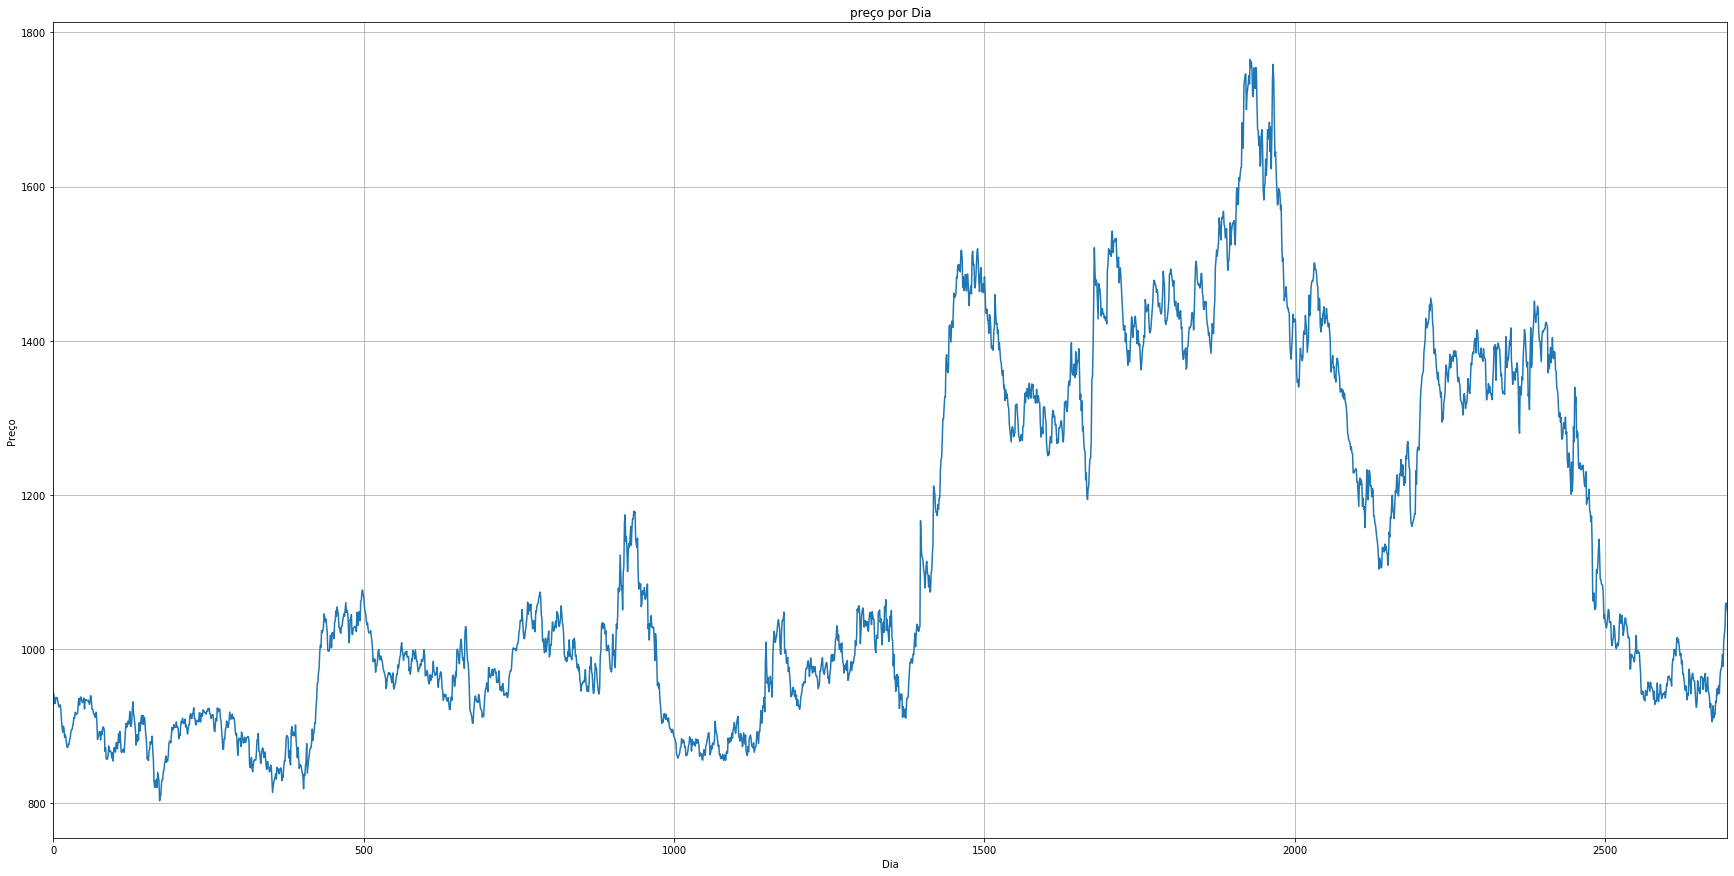

In [0]:
plt.title('preço por Dia')
plt.ylabel('Preço')
plt.xlabel('Dia')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(series['Ultimo'])

In [0]:
print(series.columns)
all_data = series['Ultimo'].values.astype(float)
print(all_data)

Index(['Dia', 'Ultimo', 'Abertura', 'Maxima', 'Minima', 'Vol.', 'Variacao'], dtype='object')
[ 943.5   939.25  929.38 ... 1059.88 1058.13 1048.63]


Separa os dados para teste e treino


In [0]:
test_data_size = (100)

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]
print('itens para treinamento', len(train_data))
print('itens para teste ', len(test_data))

itens para treinamento 2598
itens para teste  100


Faz uma preparação dos dados, normalizando os mesmos para trabalhar em escalas menores

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
print(train_data_normalized[:5])
print(train_data_normalized[-5:])
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

[[-0.70871261]
 [-0.71755527]
 [-0.73809103]
 [-0.73705072]
 [-0.72119636]]
[[-0.71104291]
 [-0.71416385]
 [-0.70871261]
 [-0.70611183]
 [-0.7230065 ]]


In [0]:
train_window = 100
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
train_inout_seq[:5]



[(tensor([-0.7087, -0.7176, -0.7381, -0.7371, -0.7212, -0.7222, -0.7222, -0.7306,
          -0.7407, -0.7472, -0.7425, -0.7415, -0.7560, -0.7844, -0.8039, -0.8151,
          -0.7987, -0.8049, -0.8291, -0.8219, -0.8304, -0.8445, -0.8559, -0.8564,
          -0.8479, -0.8479, -0.8367, -0.8315, -0.8153, -0.8083, -0.8078, -0.7987,
          -0.7899, -0.7753, -0.7779, -0.7615, -0.7638, -0.7675, -0.7644, -0.7633,
          -0.7363, -0.7238, -0.7420, -0.7280, -0.7202, -0.7233, -0.7332, -0.7347,
          -0.7316, -0.7233, -0.7527, -0.7285, -0.7269, -0.7285, -0.7295, -0.7306,
          -0.7287, -0.7347, -0.7399, -0.7300, -0.7165, -0.7277, -0.7524, -0.7529,
          -0.7592, -0.7664, -0.7664, -0.7748, -0.7722, -0.7612, -0.7904, -0.8346,
          -0.8247, -0.8231, -0.8133, -0.8174, -0.8359, -0.8127, -0.8221, -0.8101,
          -0.8008, -0.8029, -0.8101, -0.8668, -0.8570, -0.8871, -0.8876, -0.8876,
          -0.8788, -0.8523, -0.8679, -0.8653, -0.8653, -0.8715, -0.8845, -0.8710,
          -0.892

Cria a classe LSTM, responsavel por realziar a previsão, definido com 100 camadas ocultas para realizar o aprendizado e a previsão


In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size), torch.zeros(1,1,self.hidden_layer_size))
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions

In [0]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Realiza o treino na quantia de épocas definidas

In [0]:
epochs = 5

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.  zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Streaming output truncated to the last 5000 lines.
epoch:   3 loss: 0.0005517408
epoch:   3 loss: 0.00005886
epoch:   3 loss: 0.0000588556
epoch:   4 loss: 0.02481606
epoch:   4 loss: 0.0248160604
epoch:   4 loss: 0.01607086
epoch:   4 loss: 0.0160708614
epoch:   4 loss: 0.01362348
epoch:   4 loss: 0.0136234751
epoch:   4 loss: 0.01418815
epoch:   4 loss: 0.0141881527
epoch:   4 loss: 0.00704401
epoch:   4 loss: 0.0070440117
epoch:   4 loss: 0.00137109
epoch:   4 loss: 0.0013710898
epoch:   4 loss: 0.00127445
epoch:   4 loss: 0.0012744486
epoch:   4 loss: 0.00055539
epoch:   4 loss: 0.0005553864
epoch:   4 loss: 0.00079712
epoch:   4 loss: 0.0007971174
epoch:   4 loss: 0.00023951
epoch:   4 loss: 0.0002395104
epoch:   4 loss: 0.00081425
epoch:   4 loss: 0.0008142497
epoch:   4 loss: 0.00190082
epoch:   4 loss: 0.0019008152
epoch:   4 loss: 0.00279046
epoch:   4 loss: 0.0027904576
epoch:   4 loss: 0.00245196
epoch:   4 loss: 0.0024519598
epoch:   4 loss: 0.00107736
epoch:   4 loss: 0.00

In [0]:
fut_pred = 100

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-0.5081820487976074, -0.49777892231941223, -0.5183355212211609, -0.523786723613739, -0.5334200263023376, -0.5227464437484741, -0.5016905069351196, -0.4840052127838135, -0.48504552245140076, -0.5196254849433899, -0.5167750120162964, -0.5175448656082153, -0.5669596791267395, -0.5815240740776062, -0.5690402984619141, -0.5617581009864807, -0.5274278521537781, -0.5347099900245667, -0.5591573715209961, -0.5851651430130005, -0.5893263816833496, -0.5810039043426514, -0.5747620463371277, -0.5820441842079163, -0.5659193992614746, -0.5149440765380859, -0.4962184727191925, -0.5214564204216003, -0.5050610899925232, -0.4998595714569092, -0.5287386178970337, -0.5539557933807373, -0.5422626733779907, -0.5227464437484741, -0.5068920850753784, -0.5074121952056885, -0.5258673429489136, -0.527178168296814, -0.545903742313385, -0.560197651386261, -0.5581170320510864, -0.5622782707214355, -0.6449831128120422, -0.6434226036071777, -0.6052015423774719, -0.605451226234436, -0.6127334237098694, -0.613003909587

In [0]:
model.eval()
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        #test_inputs.append(model(seq).item())

In [0]:
test_inputs[fut_pred:]
actual_predictions = scaler.inverse_transform(np.array(test_inputs[:train_window] ).reshape(-1, 1))
print(actual_predictions)
x = np.arange(132, 144, 1)
print(x)

[[1039.8800028 ]
 [1044.88000546]
 [1034.99999011]
 [1032.38000596]
 [1027.74999986]
 [1032.87999047]
 [1043.0000001 ]
 [1051.49999461]
 [1050.99999577]
 [1034.3800013 ]
 [1035.75000985]
 [1035.37999897]
 [1011.63000422]
 [1004.6299919 ]
 [1010.63000655]
 [1014.13001271]
 [1030.62998856]
 [1027.13001104]
 [1015.37998831]
 [1002.88000314]
 [1000.8800078 ]
 [1004.87999848]
 [1007.87999148]
 [1004.38001397]
 [1012.12998873]
 [1036.63000321]
 [1045.62999655]
 [1033.50000793]
 [1041.38001362]
 [1043.87999347]
 [1030.00000177]
 [1017.87999681]
 [1023.50000261]
 [1032.87999047]
 [1040.49999161]
 [1040.25001368]
 [1031.3800083 ]
 [1030.74999286]
 [1021.75001385]
 [1014.8800038 ]
 [1015.88000147]
 [1013.88000613]
 [ 974.1299914 ]
 [ 974.88001114]
 [ 993.25000869]
 [ 993.13000439]
 [ 989.62999823]
 [ 989.49999595]
 [ 988.24999171]
 [ 983.50000995]
 [ 994.99999745]
 [ 998.63000589]
 [1017.87999681]
 [ 994.50001294]
 [ 997.24999937]
 [ 997.75001252]
 [ 995.25000403]
 [ 995.87999082]
 [ 981.3800103

In [0]:
len(test_inputs)

100

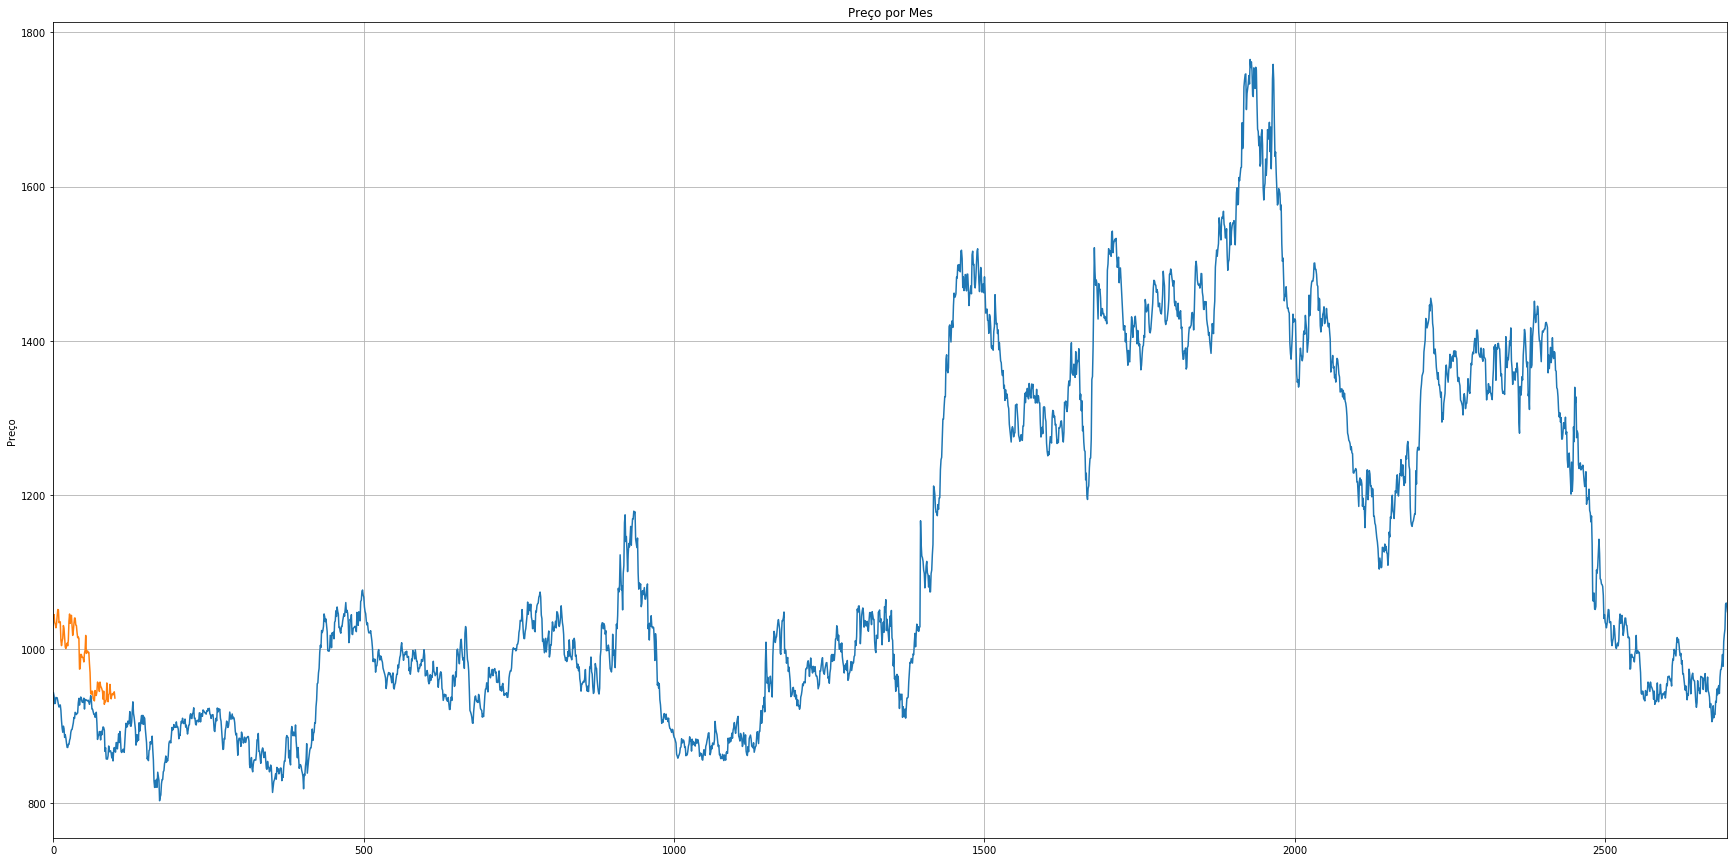

In [0]:
plt.title('Preço por Mes')
plt.ylabel('Preço')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(series['Ultimo'])
plt.plot(actual_predictions)
plt.show()

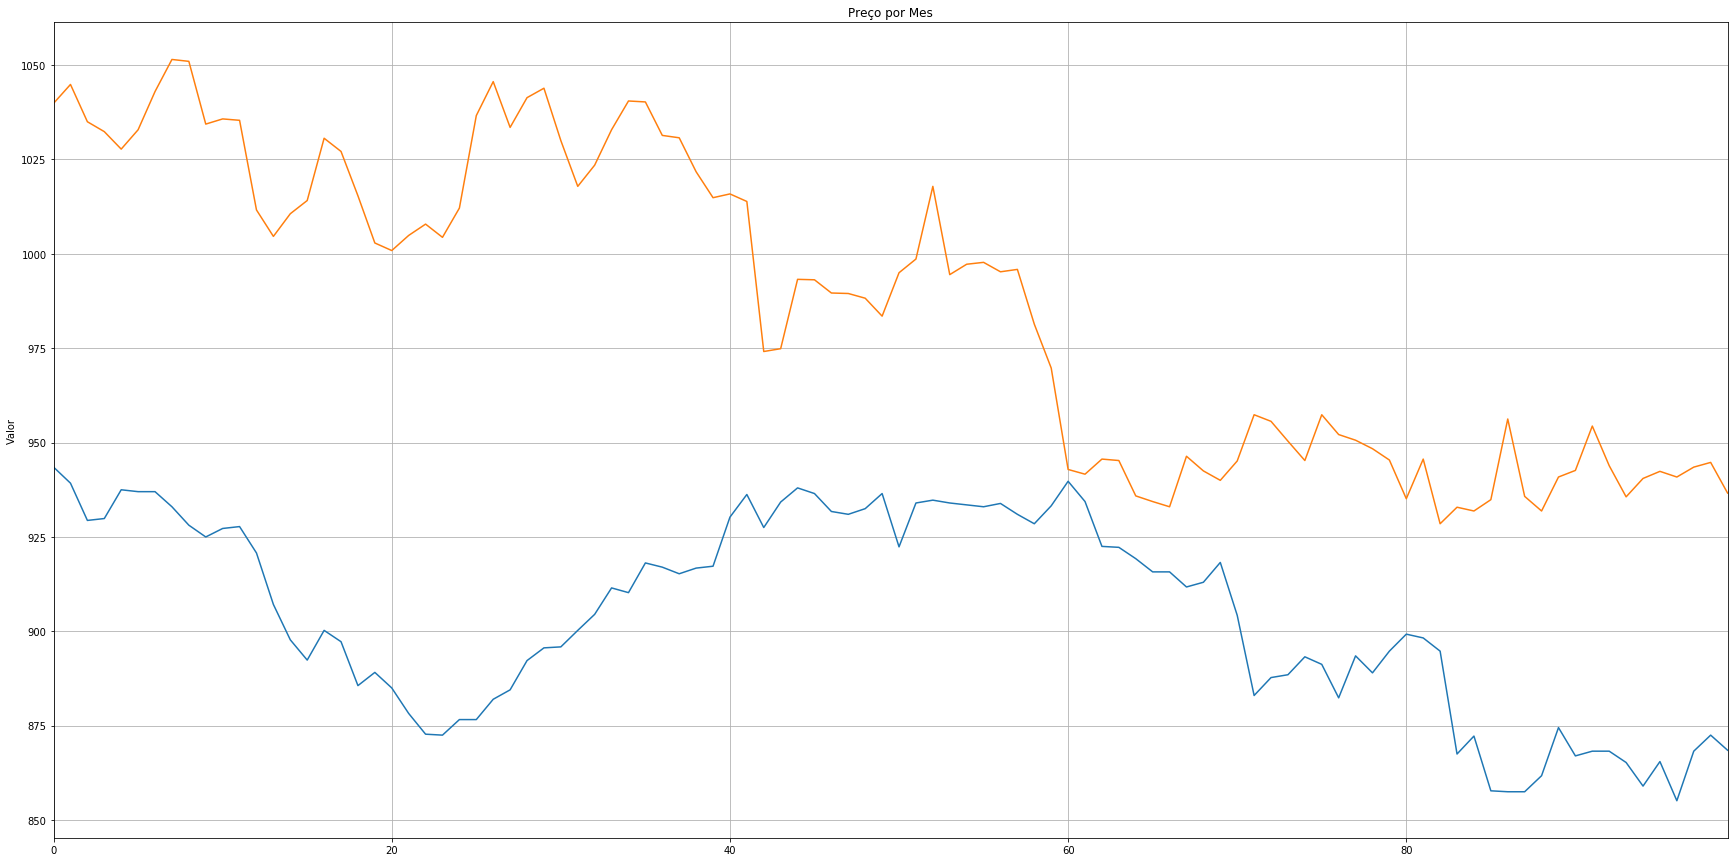

In [0]:
plt.title('Preço por Mes')
plt.ylabel('Valor')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(series['Ultimo'][:train_window])
plt.plot(actual_predictions)
plt.show()

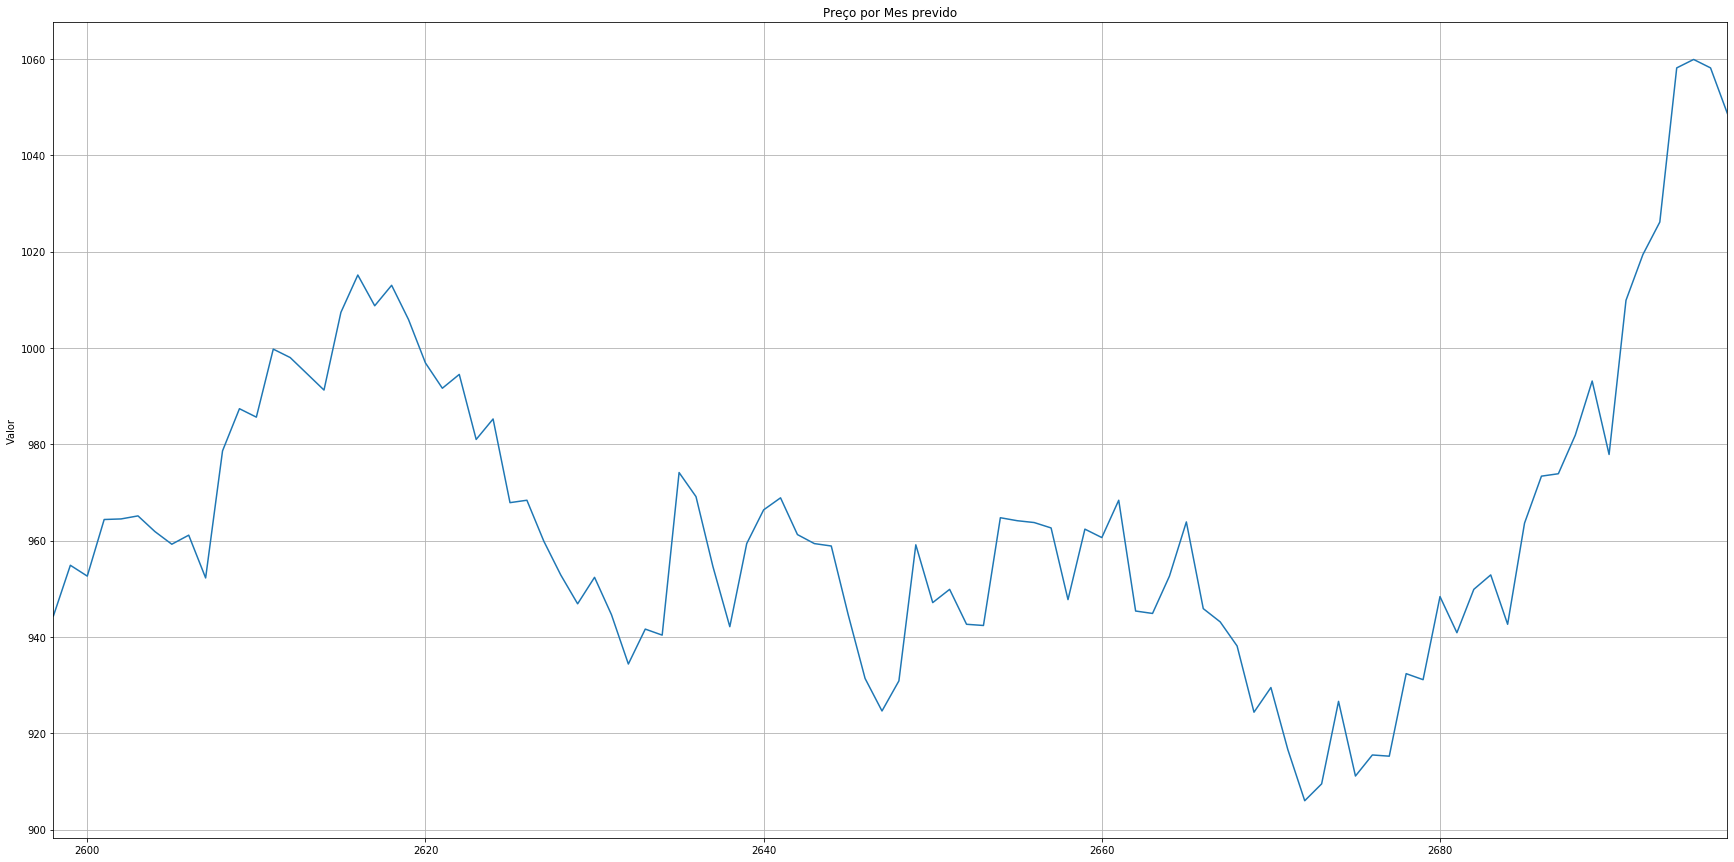

In [0]:
plt.title('Preço por Mes prevido')
plt.ylabel('Valor')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(series['Ultimo'][-train_window:])
#plt.plot(actual_predictions)
plt.show()